In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from qiskit import *
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session,Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
 
# Add your token below
service = QiskitRuntimeService(
    channel="ibm_quantum", token='cd677d66a7ae5d149626c321a1f19ed7ba6db780919f46c41d57e78054f2e243c827e5e94904d509da23d332db7a97c9365487c7d1db6d5cc6a9028c0d393af2')

backend = service.backend("ibm_rensselaer") #change to RPI
session = Session(backend=backend)


# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

sampler = Sampler(session=session)
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)


In [2]:


#load processed data (location fire hazard, precipitation, powerplants, earthquake)
# Assuming the CSV file is in the same directory as your script or Jupyter notebook
file_path = 'geo_fire_precip_gen_eq.csv'

# Read the CSV file into a pandas DataFrame
df_geo= pd.read_csv(file_path)

# Assuming the CSV file is in the same directory as your script or Jupyter notebook
#load processed data (state, precipitation, disaster declrations, power disturbances)
file_path = 'state_precip_disas_break_.csv'

# Read the CSV file into a pandas DataFrame
df_month= pd.read_csv(file_path)

In [3]:
#preprocessing the data
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_geo is your DataFrame
# Let's encode the categorical variables using LabelEncoder
le_state = LabelEncoder()
le_generation = LabelEncoder()
le_fire_risk = LabelEncoder()

df_geo['state'] = le_state.fit_transform(df_geo['state'])
df_geo['generation'] = le_generation.fit_transform(df_geo['generation'])
df_geo['fire_risk'] = le_fire_risk.fit_transform(df_geo['fire_risk'])

# Extract features and target variable
X_categorical = df_geo[['state', 'generation', 'fire_risk']]
X_numeric = df_geo[['precipitation']]  # Add other numeric columns as needed

# Concatenate categorical and numeric features
X = pd.concat([X_categorical, X_numeric], axis=1)

y = df_geo['earthquake risk']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# features = MinMaxScaler().fit_transform(X_train.values)

In [4]:
#%%   Train Quantum NN for Fire risk


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import VQC

algorithm_globals.random_seed = 42

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

num_features=4

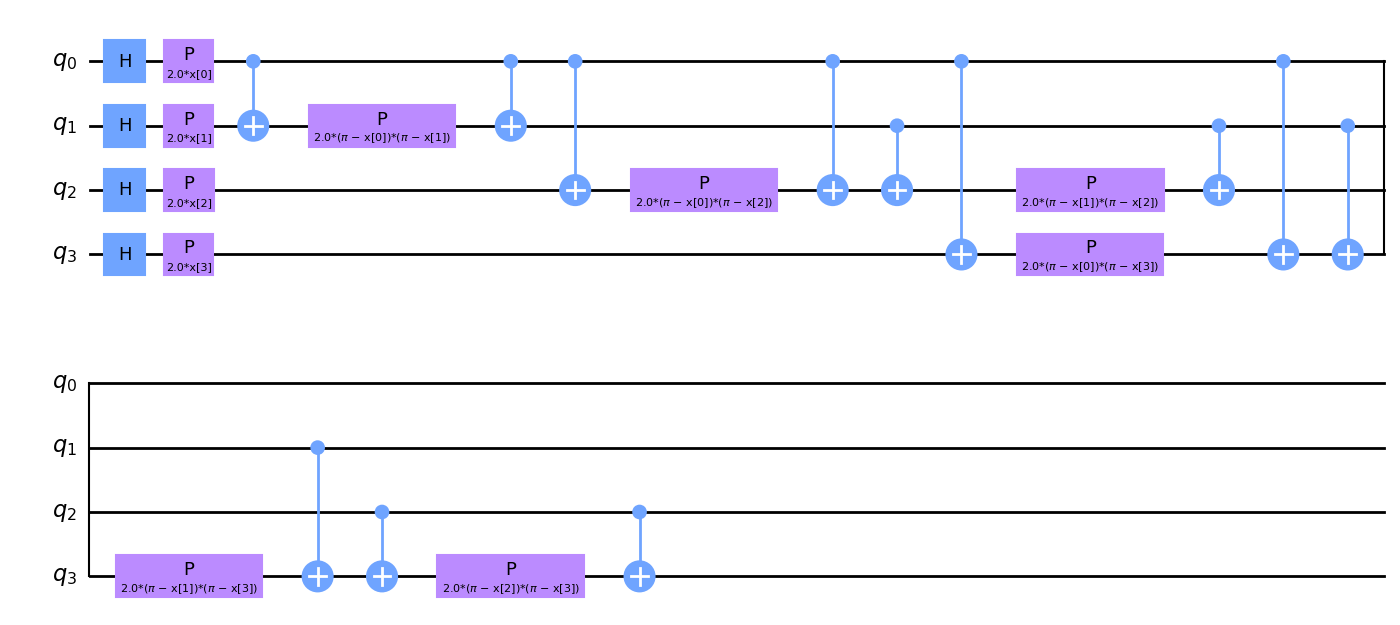

In [5]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


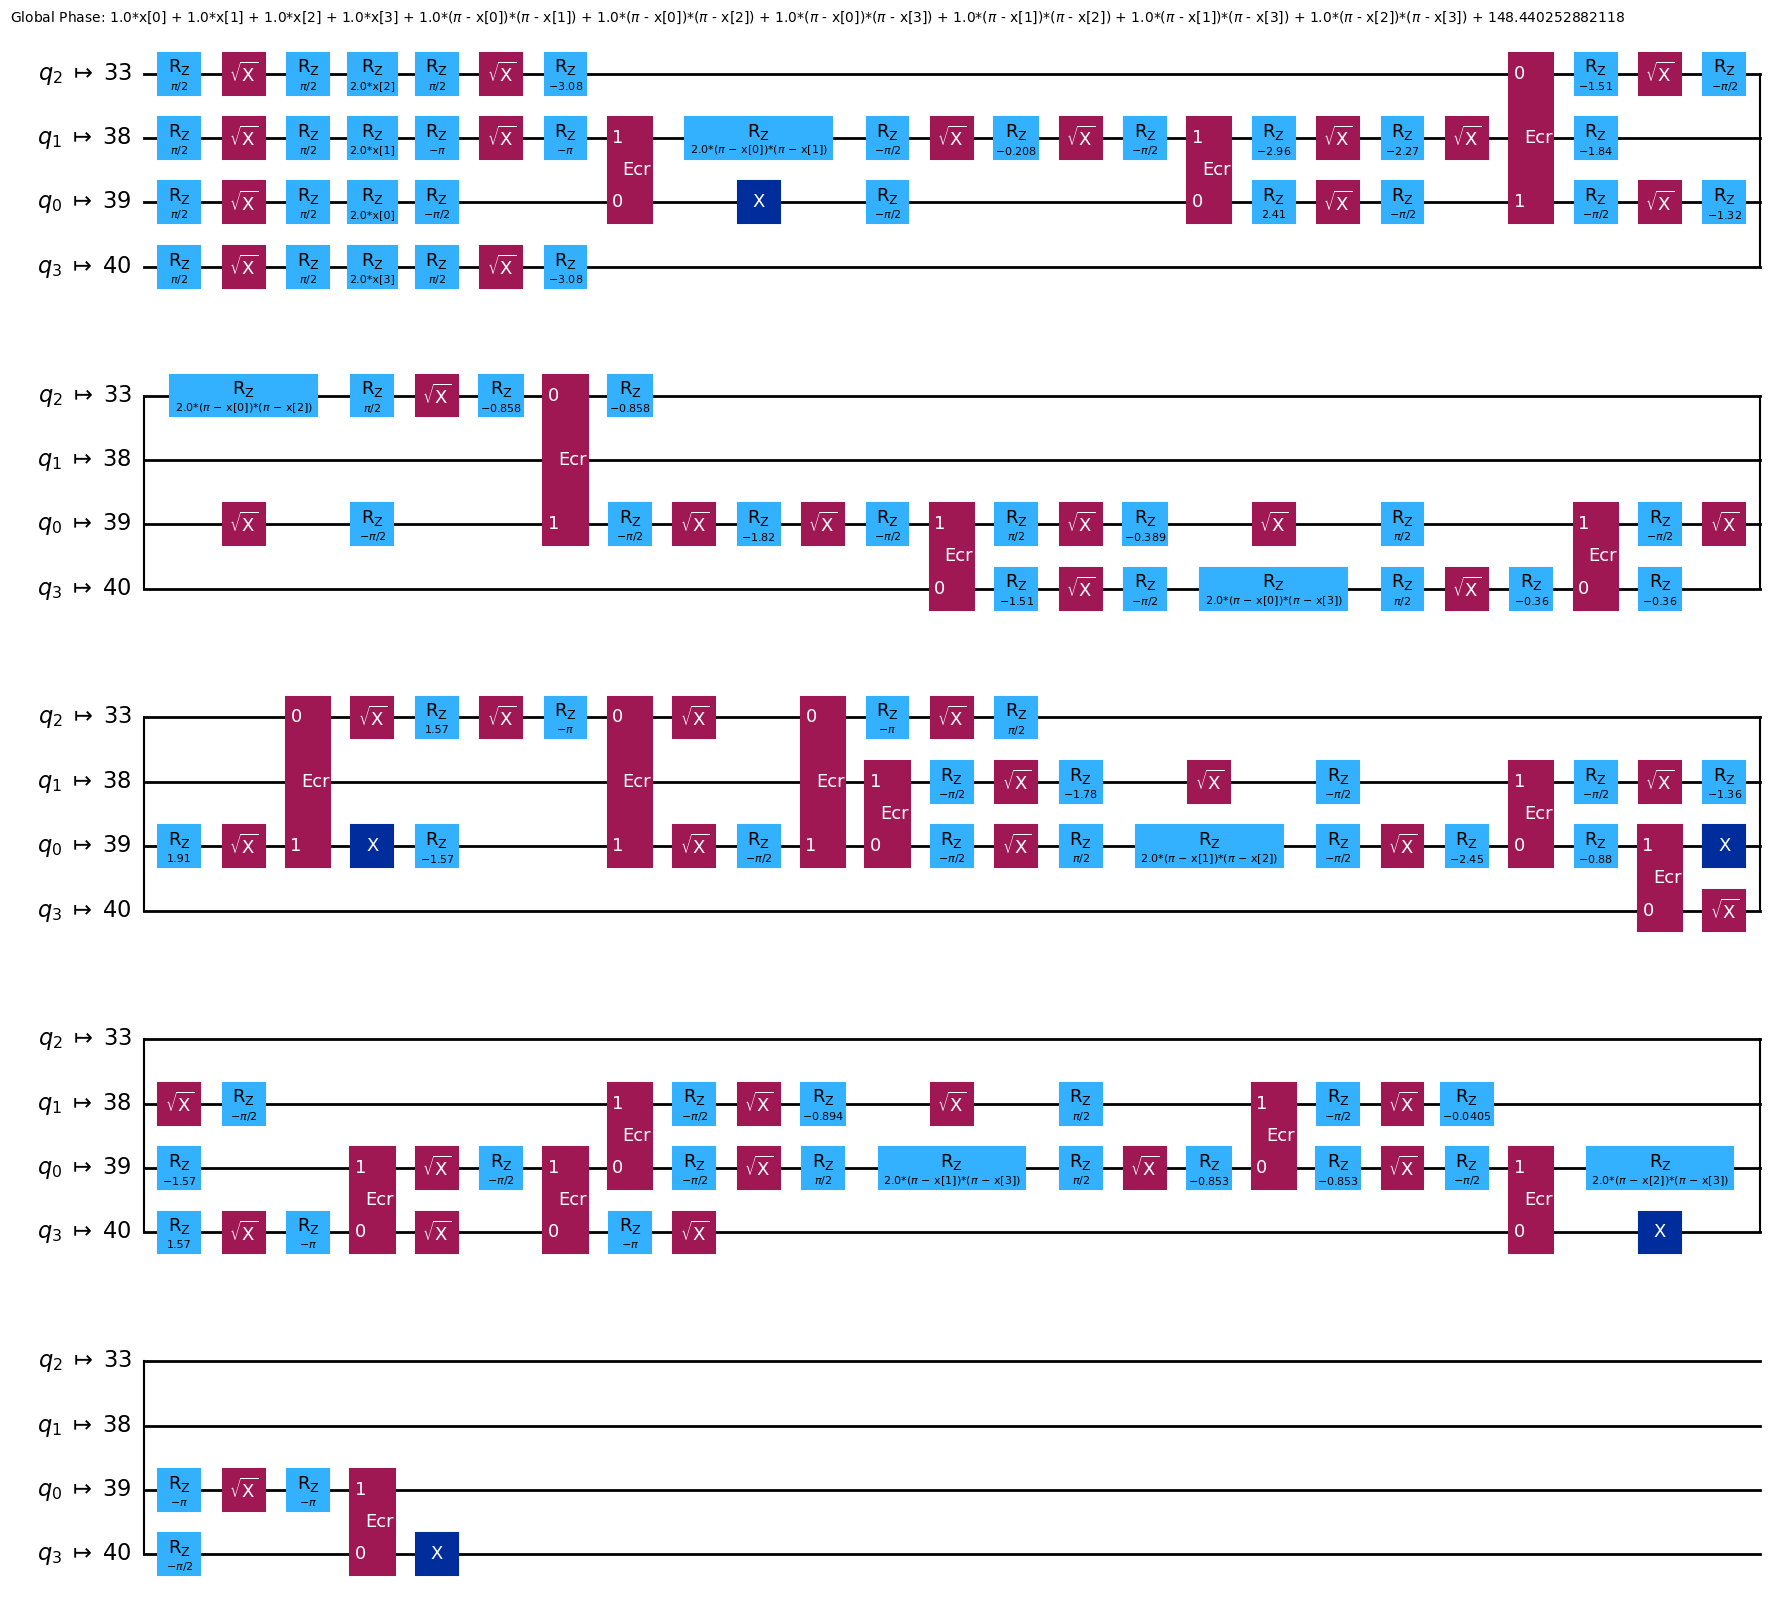

In [6]:
# Transpile it by calling the run method of the pass manager
transpiled = pass_manager.run(feature_map)
 
# Draw it, excluding idle qubits from the diagram
transpiled.draw("mpl", idle_wires=False)

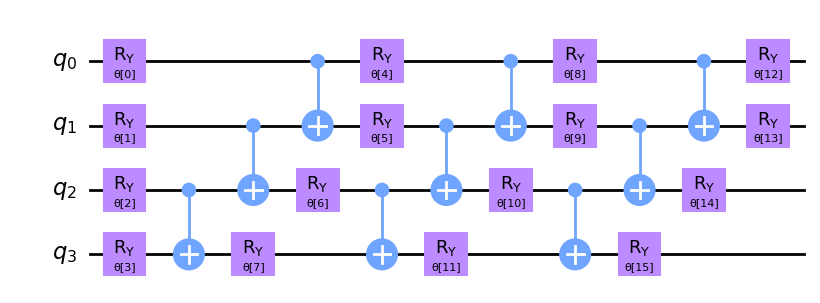

In [7]:
ansatz = RealAmplitudes(num_qubits=4, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

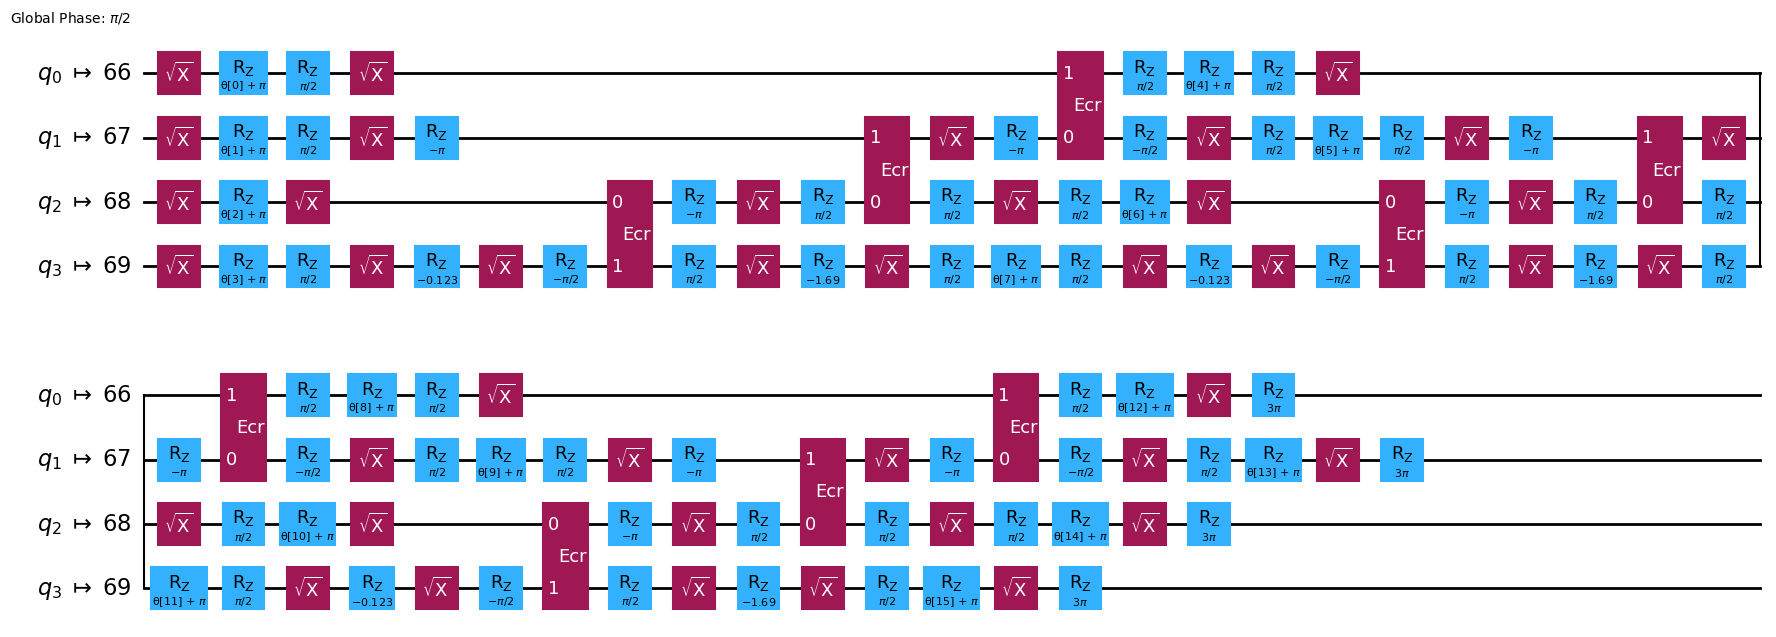

In [8]:
# Transpile it by calling the run method of the pass manager
transpiled_ansatz = pass_manager.run(ansatz)
 
# Draw it, excluding idle qubits from the diagram
transpiled_ansatz.draw("mpl", idle_wires=False)

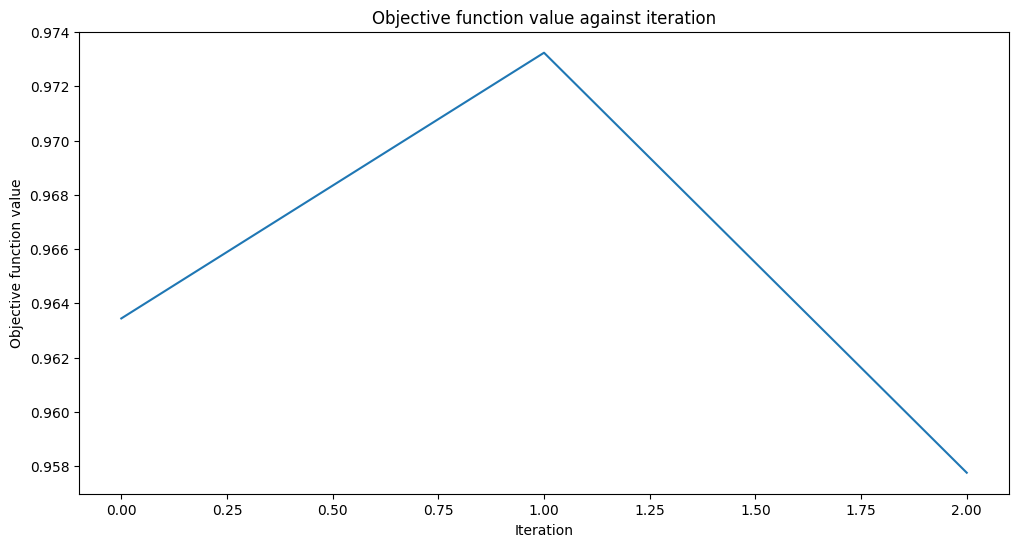

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [9]:
vqc = VQC(
    sampler=sampler,
    feature_map=transpiled,
    ansatz=transpiled_ansatz,
    optimizer=COBYLA(maxiter=10),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# y_cat = np.empty(y_train.values.shape, dtype=str)
# y_cat[y_train.values == 0] = "A"
# y_cat[y_train.values == 1] = "B"
# y_cat[y_train.values == 2] = "C"
# print(y_cat)
# fit classifier to data
vqc=vqc.fit(X_train.values, y_train.values)

In [10]:
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:  {y_test.values}")

# evaluate data points
y_predict =predict

# # plot results
# # red == wrongly classified
# for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
#     if y_target == 1:
#         plt.plot(x[0], x[1], "bo")
#     else:
#         plt.plot(x[0], x[1], "go")
#     if y_target != y_p:
#         plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.plot([-1, 1], [1, -1], "--", color="black")
# plt.show()

from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)

QiskitMachineLearningError: 'The model has not been fitted yet'

In [ ]:
#%%  Train for Earthquake risk

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming df_geo is your DataFrame
# Let's encode the categorical variables using LabelEncoder
le_state = LabelEncoder()
le_generation = LabelEncoder()
le_fire_risk = LabelEncoder()

df_geo['state'] = le_state.fit_transform(df_geo['state'])
df_geo['generation'] = le_generation.fit_transform(df_geo['generation'])
df_geo['fire_risk'] = le_fire_risk.fit_transform(df_geo['fire_risk'])

# Extract features and target variable
X_categorical = df_geo[['state', 'generation', 'earthquake risk']]
X_numeric = df_geo[['precipitation']]  # Add other numeric columns as needed

# Concatenate categorical and numeric features
X = pd.concat([X_categorical, X_numeric], axis=1)

y = df_geo['fire_risk']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#%%   Train Quantum NN for Earthquake risk

vqc = VQC(
    sampler=sampler,
    feature_map=transpiled,
    ansatz=transpiled_ansatz,
    optimizer=COBYLA(maxiter=10),
    callback=callback_graph,
)


# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train.values, y_train.values)


# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test.values}")

# evaluate data points
y_predict =predict

# # plot results
# # red == wrongly classified
# for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
#     if y_target == 1:
#         plt.plot(x[0], x[1], "bo")
#     else:
#         plt.plot(x[0], x[1], "go")
#     if y_target != y_p:
#         plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.plot([-1, 1], [1, -1], "--", color="black")
# plt.show()


from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)


In [ ]:

#%% Train disaster breakdown
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming df_month is your DataFrame
# Make sure to encode categorical variables into numerical values
le_month = LabelEncoder()
le_state = LabelEncoder()
le_disaster = LabelEncoder()

df_month['month'] = le_month.fit_transform(df_month['month'])
df_month['state'] = le_state.fit_transform(df_month['state'])
df_month['disaster'] = le_disaster.fit_transform(df_month['disaster'])

# Define features (X) and target variable (y)
X = df_month[['month', 'state', 'disaster', 'precipitation']]
y = df_month['break_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#%% Train  Quantum NN for disaster breakdown

#%%   Train Quantum NN for Earthquake risk

vqc = VQC(
    sampler=sampler,
    feature_map=transpiled,
    ansatz=transpiled_ansatz,
    optimizer=COBYLA(maxiter=10),
    callback=callback_graph,
)


# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train.values, y_train.values)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train.values,y_train.values)


predict = vqc.predict(X_test.values)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test.values}")

# evaluate data points
y_predict =predict

# # plot results
# # red == wrongly classified
# for x, y_target, y_p in zip(X_test.values, y_test.values, y_predict):
#     if y_target == 1:
#         plt.plot(x[0], x[1], "bo")
#     else:
#         plt.plot(x[0], x[1], "go")
#     if y_target != y_p:
#         plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.plot([-1, 1], [1, -1], "--", color="black")
# plt.show()


from sklearn.metrics import classification_report
import torch

# Assuming you have the true labels (y_test) and predicted labels (predicted)
# Convert tensors to numpy arrays
y_test_np = y_test.values
predicted_np = predict

# Generate classification report
report = classification_report(y_test_np, predicted_np)

# Print the report
print(report)
